In [1]:
from google.colab import drive
isMount=!df |grep /content/drive
if len(isMount)<1: drive.mount('/content/drive')


Mounted at /content/drive


# CNN Example From Flowers by Keras (Color Version)


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
from tensorflow.keras import datasets, layers, models, regularizers

from os import listdir
from os.path import isfile, join
import random
import warnings



import numpy as np
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam



IMG_W=150
IMG_H=150

In [3]:
def getFolder(thePath,isFile=True):
    return [f for f in listdir(thePath) if isFile == isfile(join(thePath, f)) ]


def getImagesAndLabels(tPath):
    labels=getFolder(tPath,False)

    
    tImages,tLabels=None,None

    for label in labels:
        imgFolder=join(tPath,label)
        files= [f for f in listdir(imgFolder) if isfile(join(imgFolder, f))]
        for file in files:
            imageFile=join(imgFolder,file)
            img=plt.imread(imageFile)
            img = cv2.resize(img, (IMG_W,IMG_H))
            if tImages is None:
                tImages, tLabels =[img], [label]
            else:
                tImages.append( img )
                tLabels.append(label)
        print("finish=",label,"total=",len(tImages))
    return (tImages,tLabels,len(labels))

In [4]:
%%bash
x=$(dpkg -l|grep imagemagick);[ ${#x} -eq 0 ]&&sudo apt install -y imagemagick
[ ! -f /content/drive/MyDrive/Lec_Capture/_data/flower_photos.tgz  ]&&wget http://download.tensorflow.org/example_images/flower_photos.tgz -O /content/drive/MyDrive/Lec_Capture/_data/flower_photos.tgz 
tar xzf /content/drive/MyDrive/Lec_Capture/_data/flower_photos.tgz 
find ./flower_photos|grep jpg|head -n 10|xargs -i -t identify {} 2>>/tmp/log

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono ghostscript gsfonts
  imagemagick-6-common imagemagick-6.q16 libcupsfilters1 libcupsimage2
  libdjvulibre-text libdjvulibre21 libgs9 libgs9-common libijs-0.35
  libjbig2dec0 liblqr-1-0 libmagickcore-6.q16-3 libmagickcore-6.q16-3-extra
  libmagickwand-6.q16-3 libnetpbm10 libwmf0.2-7 netpbm poppler-data
Suggested packages:
  fonts-noto ghostscript-x imagemagick-doc autotrace cups-bsd | lpr | lprng
  enscript gimp gnuplot grads hp2xx html2ps libwmf-bin mplayer povray radiance
  sane-utils texlive-base-bin transfig ufraw-batch inkscape libjxr-tools
  libwmf0.2-7-gtk poppler-utils fonts-japanese-mincho | fonts-ipafont-mincho
  fonts-japanese-gothic | fonts-ipafont-gothic fonts-arphic-ukai
  fonts-arphic-uming fonts-nanum
The following NEW packages will be installed:
  fonts-droid-fallback fonts-noto-mono ghostscript gsf



debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 23.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


In [5]:
from sklearn.model_selection import train_test_split
basePath='./flower_photos'
imgs,labels,class_cnt=getImagesAndLabels(basePath)


finish= roses total= 641
finish= dandelion total= 1539
finish= daisy total= 2172
finish= tulips total= 2971
finish= sunflowers total= 3670


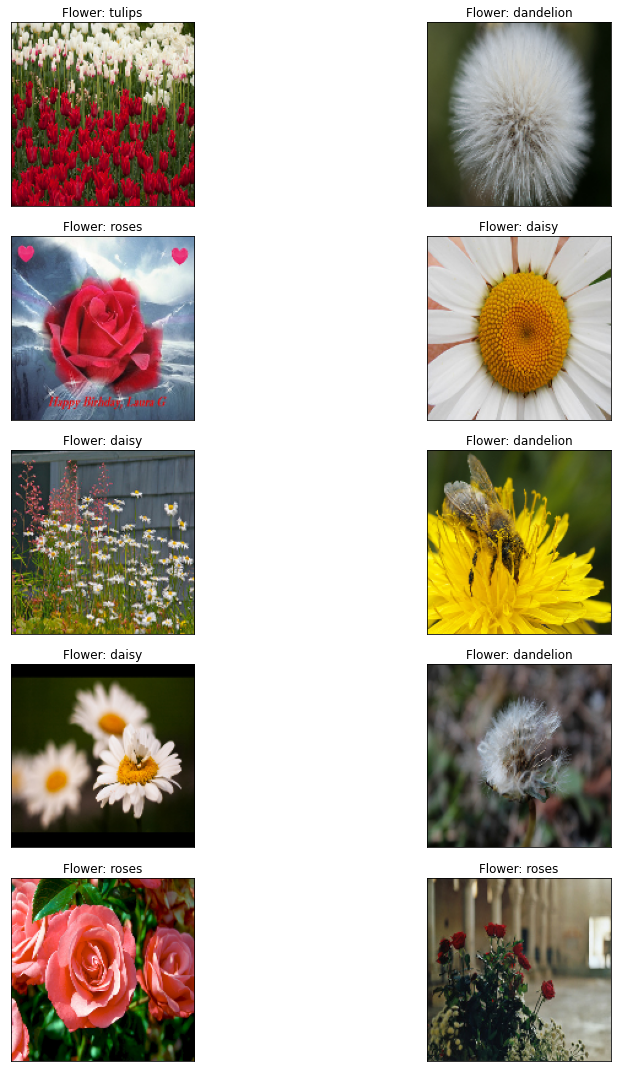

In [6]:
count=0
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range (5):
    for j in range (2):
        l=random.randint(0,len(imgs))
        ax[i,j].imshow(imgs[l])
        ax[i,j].set_title('Flower: '+ labels[l])
        ax[i,j].grid(False)
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        count+=1
plt.tight_layout()


In [7]:
le=LabelEncoder()
labels=np.array(labels)

Y=le.fit_transform(labels)
Y=to_categorical(Y,class_cnt)
imgs=np.array(imgs)
imgs=imgs/255.

In [8]:
train_images,test_images,train_labels,test_labels=train_test_split(imgs,Y,test_size=0.25, random_state=99)

In [9]:
np.random.seed(42)
random.seed(42)
tf.compat.v1.set_random_seed(42)

In [10]:

model = models.Sequential()
model.add(layers.Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(layers.MaxPooling2D(pool_size=(2,2)))


model.add(layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 

model.add(layers.Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(layers.Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(512))
model.add(layers.Activation('sigmoid'))
model.add(layers.Dense(5, activation = "softmax"))

In [11]:
batch_size=128
epochs=50

from tensorflow.python.keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

In [12]:

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(train_images)

In [13]:


model.compile(optimizer=Adam(lr=0.001),\
              loss='categorical_crossentropy',metrics=['accuracy'])


In [14]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 96)        55392     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 96)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 96)        8

In [15]:
batch_size=80
epochs=20
History = model.fit_generator(datagen.flow(train_images,train_labels, batch_size=batch_size),
                      epochs = epochs, validation_data = (test_images,test_labels), steps_per_epoch=train_images.shape[0] // batch_size)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
34/34 [==============================] - 13s 393ms/step - loss: 1.3788 - accuracy: 0.4008 - val_loss: 1.1151 - val_accuracy: 0.5359
Epoch 2/20
34/34 [==============================] - 13s 387ms/step - loss: 1.1354 - accuracy: 0.5254 - val_loss: 1.1146 - val_accuracy: 0.5795
Epoch 3/20
34/34 [==============================] - 13s 383ms/step - loss: 1.0377 - accuracy: 0.5872 - val_loss: 0.9178 - val_accuracy: 0.6307
Epoch 4/20
34/34 [==============================] - 13s 381ms/step - loss: 0.9678 - accuracy: 0.6175 - val_loss: 0.8737 - val_accuracy: 0.6580
Epoch 5/20
34/34 [==============================] - 13s 378ms/step - loss: 0.9163 - accuracy: 0.6426 - val_loss: 0.8316 - val_accuracy: 0.6710
Epoch 6/20
34/34 [==============================] - 13s 372ms/step - loss: 0.8379 - accuracy: 0.6808 - val_loss: 0.7811 - val_accuracy: 0.6906
Epoch 7/20
34/34 [==============================] - 12s 366ms/step

In [16]:
score = model.evaluate(test_images, test_labels, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6021994352340698
Test accuracy: 0.7734204530715942


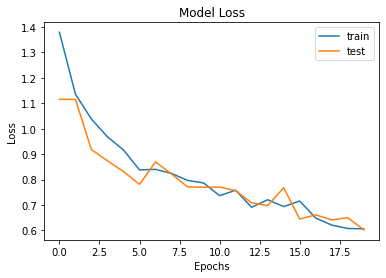

In [17]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()


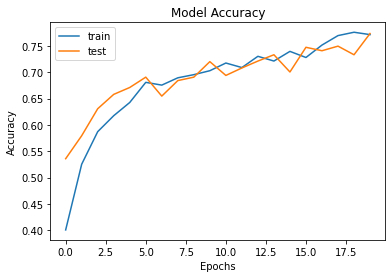

In [18]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [19]:
# getting predictions on val set.
pred=model.predict(test_images)
pred_digits=np.argmax(pred,axis=1)

In [29]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

print('Pred True')
for i in range(len(test_labels)):
    if(np.argmax(test_labels[i])==pred_digits[i]):
      print(np.argmax(test_labels[i]),pred_digits[i])        
      prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
print('Pred False')
for i in range(len(test_labels)):
    if(not np.argmax(test_labels[i])==pred_digits[i]):
      print(np.argmax(test_labels[i]),pred_digits[i])        
      mis_class.append(i)
    if(len(mis_class)==8):
        break

Pred True
2 2
0 0
1 1
4 4
3 3
2 2
1 1
3 3
Pred False
1 4
1 4
0 2
4 2
3 2
4 2
4 2
4 1


--------------------------------------
 True 
--------------------------------------


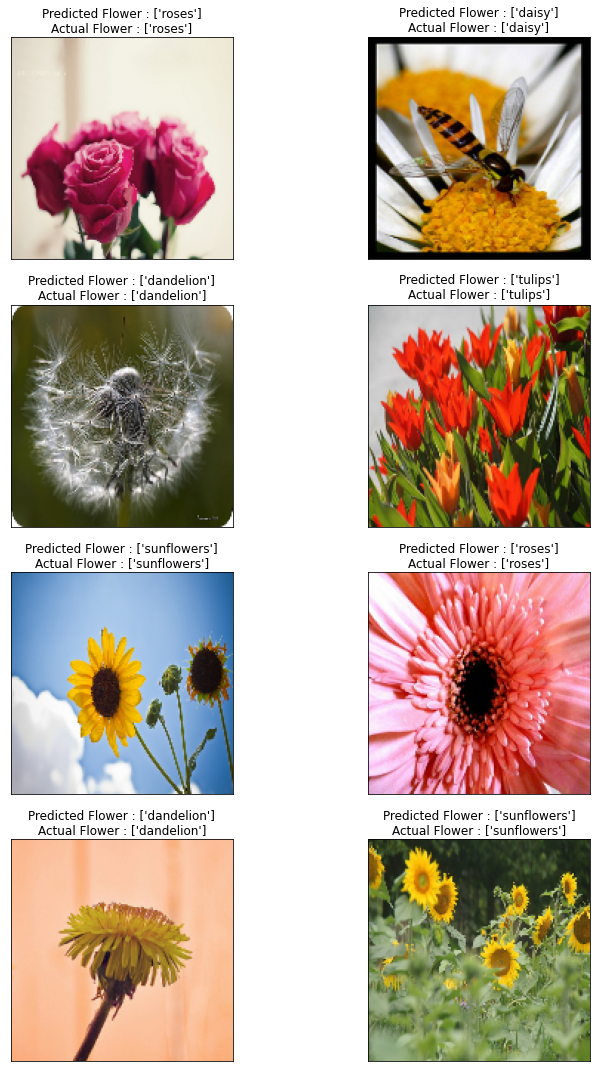

In [30]:

if len(prop_class)<8:
  print("True Prediction is lower then 8")
else:

  print('--------------------------------------')
  print(' True ')
  print('--------------------------------------')
  warnings.filterwarnings('always')
  warnings.filterwarnings('ignore')

  count=0
  fig,ax=plt.subplots(4,2)
  fig.set_size_inches(15,15)
  for i in range (4):
      for j in range (2):
          img=test_images[prop_class[count]]
          ax[i,j].imshow(img)
          ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([pred_digits     [prop_class[count      ]]]))+"\n"+ \
                            "Actual Flower : "   +str(le.inverse_transform([np.argmax(test_labels[prop_class[count      ]])]))    \
                          )
          ax[i,j].set_xticks([])
          ax[i,j].set_yticks([])

          plt.tight_layout()
          count+=1

--------------------------------------
 mis class
--------------------------------------


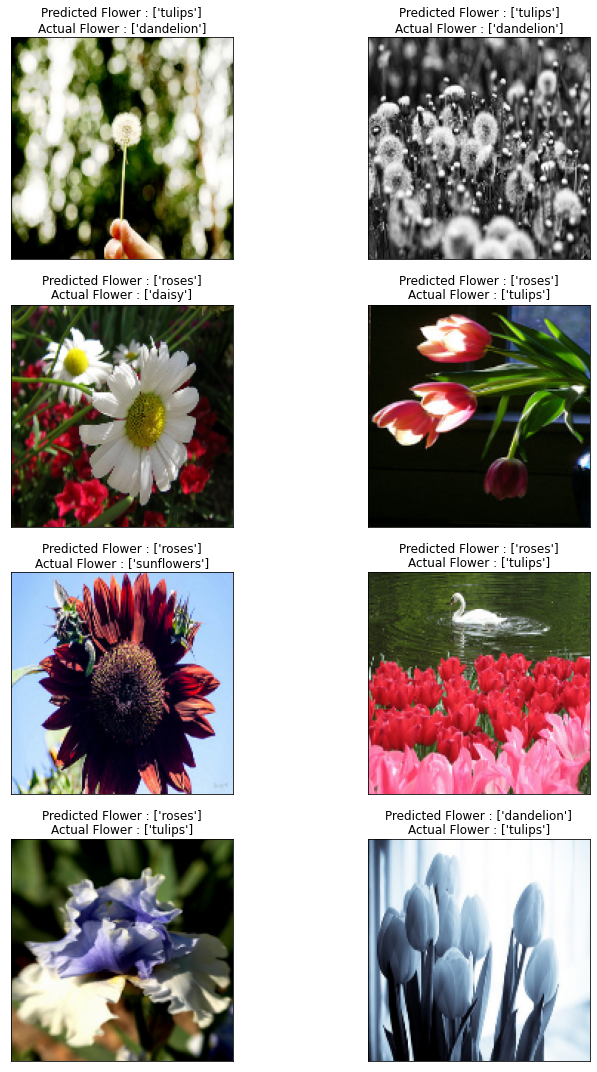

In [31]:
if len(mis_class)<8:
  print("mis_class is lower then 8")
else:
  print('--------------------------------------')
  print(' mis class')
  print('--------------------------------------')
  warnings.filterwarnings('always')
  warnings.filterwarnings('ignore')

  count=0
  fig,ax=plt.subplots(4,2)
  fig.set_size_inches(15,15)
  for i in range (4):
      for j in range (2):
          img=test_images[mis_class[count]]
          ax[i,j].imshow(img)
          ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([pred_digits[mis_class[count]]]))+"\n"+ \
                            "Actual Flower : "   +str(le.inverse_transform([np.argmax([test_labels[mis_class[count]]])])) \
                            )

          ax[i,j].set_xticks([])
          ax[i,j].set_yticks([])
          plt.tight_layout()
          count+=1
